# Modeling

First thing, I want to see what the simplest, baseline model for my data is. To do this, I will just find whatever I have that correlates the most with PRICE and then create a model with it.

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import functions

In [125]:
# Import data
kc = pd.read_csv('../../Data/matthew_clean_data.csv', index_col=0)

In [126]:
# Create Correlation matrix
kc_matrix = kc.corr()
kc_matrix['price']

id             -0.02
price           1.00
grade           0.67
yr_built        0.05
yr_renovated    0.13
floors_1.5      0.02
floors_2.0      0.23
floors_2.5      0.12
floors_3.0      0.02
floors_3.5      0.02
Name: price, dtype: float64

## Simple Model: Price ~ Grade

In [127]:
# Grade seems to have the highest correlation here. Let's start there

#Train/Test Split
X = kc.drop(columns=['price', 'date', 'yr_renovated'])
y = kc['price']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                 1.152e+04
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:28:08   Log-Likelihood:            -2.0124e+05
No. Observations:               14469   AIC:                         4.025e+05
Df Residuals:                   14467   BIC:                         4.025e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.079e+05   9071.467    -44.968      0.000   -4.26e+05    -3.9e+05
grade       2.032e+05   1892.914    107.345      0.000    1.99e+05    2.07e+05
==============================================================================
Omnibus:                    13205.766   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1397607.288
Skew:                           4.003   Prob(JB):                         0.00
Kurtosis:                      50.478   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
# For comparing the models, let's also use our evaluate() function to get R2, RMSE, MAE
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4434
Test R2: 0.4495
****
Train RMSE: $265,440.96
Test RMSE: $289,129.30
****
Train MAE: $171,685.80
Test MAE: $178,141.42


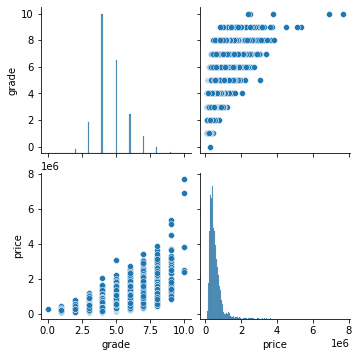

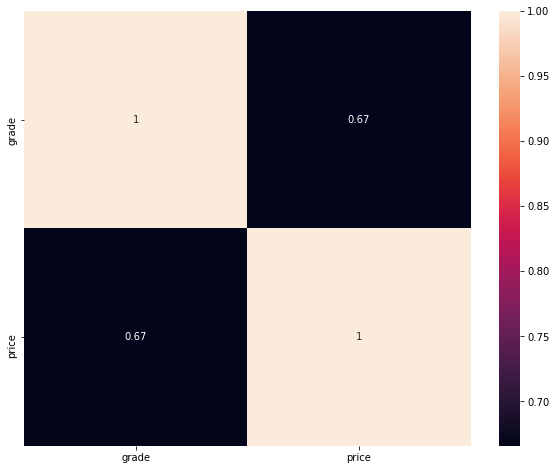

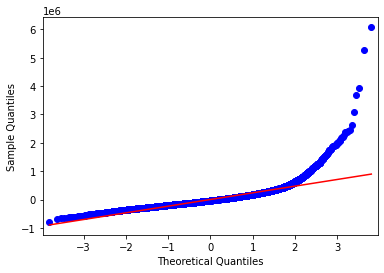

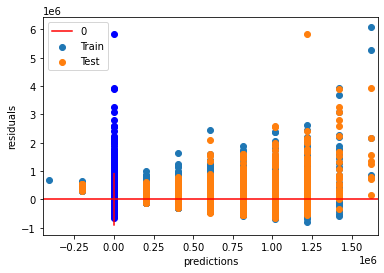

In [129]:
# Let's also check the assumptions of linearity.
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
Looking at the results two things stick out to me:
- The RMSE and MAE have a difference of about $98,000 dollars.

- This model violates the "residual normality" assumption of linear regression. The Jarque-Bera score of 1,991,063 also reinforces this.
- It may also have some heteroscedasticity as well, violating another assumption.

This is definitely a good start, but I think it would benefit any model moving forward to remove the extreme outliers.

## (Price ~ Grade) with removed outliers

In [130]:
# Remove the 5% most expensive houses
kc_trim = kc[kc['price'] < kc['price'].quantile(0.95)]

# Redo the Train/Test Split and exclude outliers
X = kc_trim.drop(columns=['price', 'date', 'yr_renovated'])
y = kc_trim['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     9230.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:28:11   Log-Likelihood:            -1.8443e+05
No. Observations:               13743   AIC:                         3.689e+05
Df Residuals:                   13741   BIC:                         3.689e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.011e+05   6195.862    -16.310      0.000   -1.13e+05   -8.89e+04
grade        1.28e+05   1332.336     96.070      0.000    1.25e+05    1.31e+05
==============================================================================
Omnibus:                      941.817   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1163.667
Skew:                           0.661   Prob(JB):                    2.06e-253
Kurtosis:                       3.531   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4018
Test R2: 0.4096
****
Train RMSE: $162,891.81
Test RMSE: $163,239.80
****
Train MAE: $128,833.74
Test MAE: $128,672.36


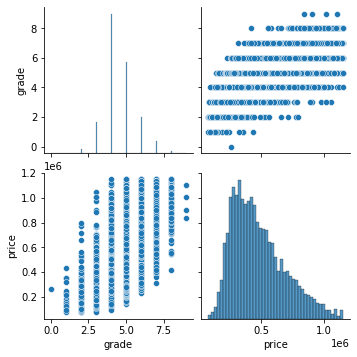

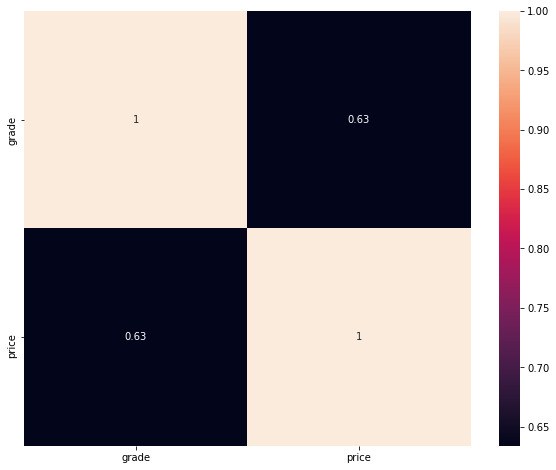

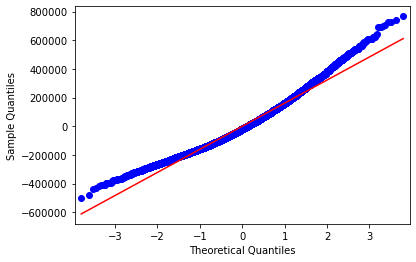

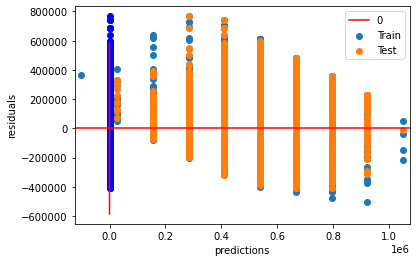

In [132]:
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
This test is interesting:
- The R-Squared went down by about 0.082

but:
- our RMSE went down by about $111,000
- our MSE went down by abour $47,000
- The model still violates the “residual normality” assumption of linear regression. However The Jarque-Bera is now 1270, *much* lower then the previous score of 1,991,063!
- The heteroscedasticity still seems to be present

Overall, I'd say this is an improvement! I think it would be smart to remove outliers like I've done here for any models moving forward. I think it would also be possible to tune the quantile I use to further improve accuracy. For now, I think it'd be better to move on.

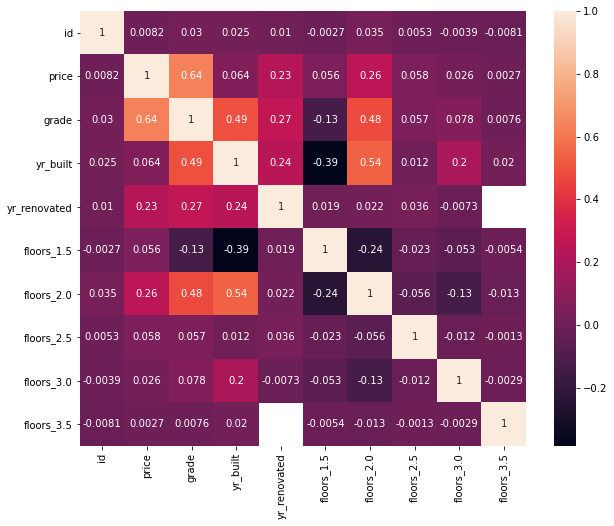

In [133]:
# Before moving forward, I'd like to check the correlation matrix again with removed outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(kc_trim.corr(), annot=True, )
plt.show()

## Renovated
Interestingly, there has been a general uptick in correlations. I think it would be a good idea to investigate the "yr_renovated" column. But let's instead create a column that indicated if a house has been renovated at all, and see if there's any correlation there.

In [160]:
kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)

<ipython-input-160-16ef9336ef54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int);


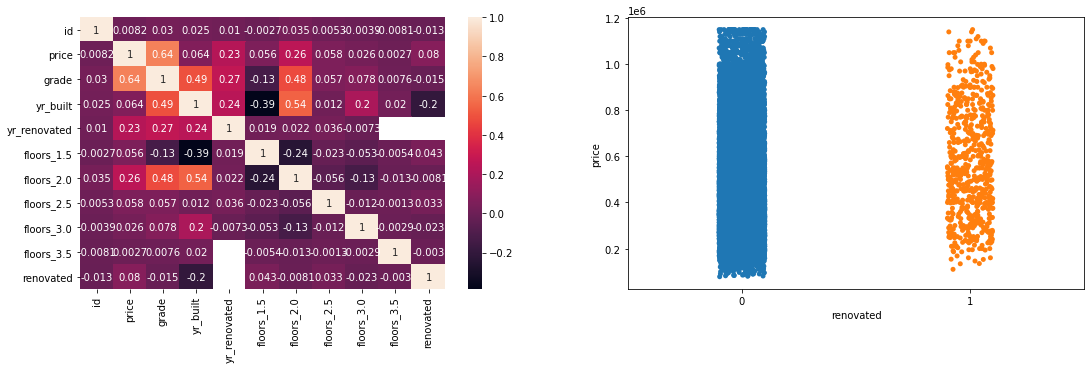

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(kc_trim.corr(), annot=True, ax=ax1)
sns.stripplot(data=kc_trim, x='renovated', y='price', ax=ax2)
plt.show()

an interesting feature, but doesn't look anymore useful then 'yr_renovated'

# Price ~ grade + floors_2.0
I'd like to see if adding 'floors_2.0' to our previous model will result in an improvement.

In [174]:
# No need to re-split since this is a new model
model = sm.OLS(y_train, sm.add_constant(X_train[['grade', 'floors_2.0']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     4676.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:01:54   Log-Likelihood:            -1.8439e+05
No. Observations:               13743   AIC:                         3.688e+05
Df Residuals:                   13740   BIC:                         3.688e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.193e+05   6535.707    -18.259      0.000   -1.32e+05   -1.07e+05
grade       1.343e+05   1517.302     88.505      0.000    1.31e+05    1.37e+05
floors_2.0 -2.829e+04   3293.651     -8.589      0.000   -3.47e+04   -2.18e+04
==============================================================================
Omnibus:                      927.978   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1148.734
Skew:                           0.651   Prob(JB):                    3.59e-250
Kurtosis:                       3.556   Cond. No.                         23.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
train_preds = model.predict(sm.add_constant(X_train[['grade', 'floors_2.0']]))
test_preds = model.predict(sm.add_constant(X_test[['grade', 'floors_2.0']]))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4050
Test R2: 0.4121
****
Train RMSE: $162,456.27
Test RMSE: $162,887.61
****
Train MAE: $128,373.30
Test MAE: $128,237.48


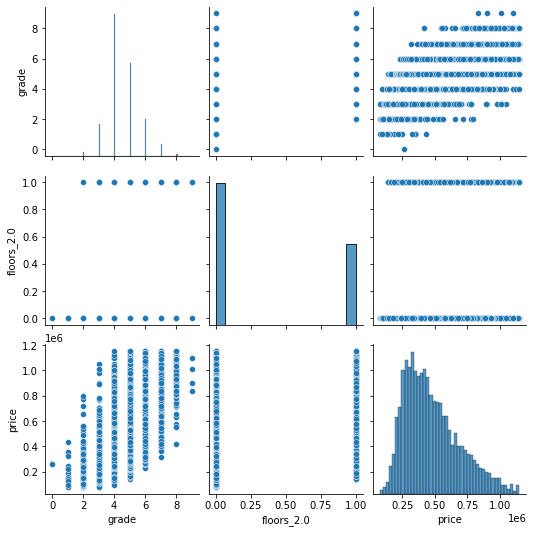

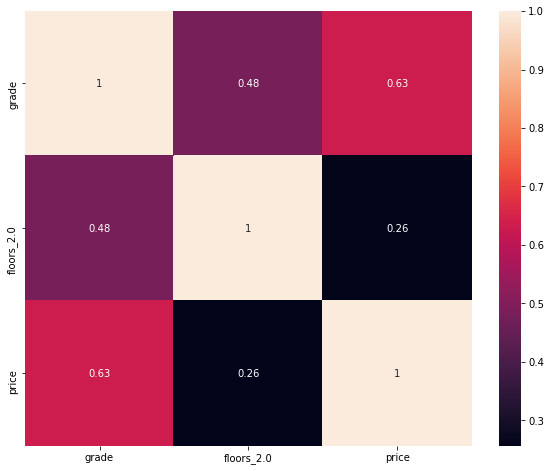

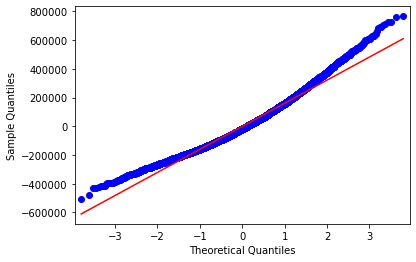

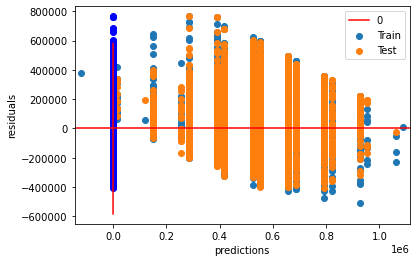

In [180]:
functions.check_assumptions(X_train[['grade', 'floors_2.0']], y_train, train_preds, test_preds, y_test)

## Conclusion
Overall, a **very small** increase in performance across all categories, but it still containes the same issues as the previous model (assumptions of linearity). This is an improvement for sure, however, I think it would be more effective to move on to combining what I have here with some of my partners' models. I think that any more experimintation here would only result in minor increase to performance, as seen in this last model.